# Example - Handwritten Digit Recognition

This example shows how to use the machine learning framework to train a model for handwritten digit recognition. For this task, we will use the MNIST dataset, which is a dataset of 28x28 grayscale images of handwritten digits (0-9). The dataset contains 42,000 training images and 10,000 test images.

In [2]:
import numpy as np

# Import required framework layers
from framework.layers import Sequential, Linear
from framework.activations import ReLU
from framework.loss import SoftmaxCrossEntropy
from framework.network import train_one_step

# set random seed for reproducibility
np.random.seed(1234)

## Create the neural network

In [3]:
# Create simple network
model = Sequential([
    Linear(28*28, 20), # 28*28 input features (flat images), 20 output features
    ReLU(), # Activation function
    Linear(20, 10), # 20 input features, 10 output features
])

# Define loss function
loss = SoftmaxCrossEntropy()

# Hyperparameters

# Learning rate: step size for the optimizer
learning_rate = 0.1
# Batch size: number of samples per batch
batch_size = 64
# Number of epochs: number of times the dataset will be passed through the network
n_epochs = 200

mod_0: <framework.layers.linear.Linear object at 0x10c5cad80>
mod_1: <framework.activations.relu.ReLU object at 0x10c5c8800>
mod_2: <framework.layers.linear.Linear object at 0x10c5ca9f0>


## Load the MNIST dataset

In [4]:
import os
from urllib import request

import numpy as np


class MNIST:
    URL = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz"

    def __init__(self, set, cache="./cache"):
        os.makedirs(cache, exist_ok=True)

        path = os.path.join(cache, "mnist.npz")
        if not os.path.isfile(path):
            request.urlretrieve(self.URL, path)

        data = np.load(path)

        assert set in ["train", "test"], "set must be either train or test"

        self.images = data["x_" + set].astype(float) / 255.0
        self.labels = data["y_" + set]

    def __len__(self) -> int:
        return self.images.shape[0]


train_validation_set = MNIST("train")
test_set = MNIST("test")

n_train = int(0.7 * len(train_validation_set))
print("MNIST:")
print("   Train set size:", n_train)
print("   Validation set size:", len(train_validation_set) - n_train)
print("   Test set size", len(test_set))

MNIST:
   Train set size: 42000
   Validation set size: 18000
   Test set size 10000


## Split the dataset into training and validation sets

In [5]:
indices = np.random.permutation(len(train_validation_set))

# Split the dataset into training and validation sets
train_indices = indices[:n_train]
validation_indices = indices[n_train:]

## Utiliy functions for validation and testing

In [6]:
from typing import Tuple


def verify(images: np.ndarray, targets: np.ndarray) -> Tuple[int, int]:
    # Forward pass
    pred = model.forward(images)

    # Comupute number of correct predictions
    # NOTE: The maximum value in the probability vector is the class chosen by the model
    #       argmax --> return the index of the maximum value == predicted class by the model
    num_ok = np.sum(np.argmax(pred, axis=1) == targets)
    # Total number of images
    total_num = targets.shape[0]
    
    return num_ok, total_num


def test() -> float:
    accumulated_ok = 0.0
    count = 0

    # use test set
    for i in range(0, len(test_set), batch_size):
        images = test_set.images[i:i + batch_size].reshape(-1, 28*28)
        labels = test_set.labels[i:i + batch_size]

        # Verify the data
        num_ok, total_num = verify(images, labels)
        accumulated_ok += num_ok
        count += total_num

    return accumulated_ok / count * 100.0


def validate() -> float:
    accumulated_ok = 0.0
    count = 0

    # use validation set
    for i in range(0, len(train_validation_set), batch_size):
        images = train_validation_set.images[i:i + batch_size].reshape(-1, 28*28)
        labels = train_validation_set.labels[i:i + batch_size]

        # Verify the data
        num_ok, total_num = verify(images, labels)
        accumulated_ok += num_ok
        count += total_num

    return accumulated_ok/count * 100.0

## Training model with early stopping

Rather than training the model for a fixed number of epochs, we will use early stopping to stop training when the validation loss stops decreasing. This helps prevent overfitting and can improve the generalization of the model.

In [7]:
best_validation_accuracy = 0
best_epoch = -1

print("Training the model...")
print("Shape of the training set: ", train_validation_set.images[train_indices].shape)
print("Shape of the labels: ", train_validation_set.labels[train_indices].shape)

for epoch in range(200):
    # Train the model using the training set
    train_set = train_validation_set.images[train_indices]
    target = train_validation_set.labels[train_indices]

    count = 0
    total_ok = 0
    for i in range(0, len(train_set), batch_size):
        # Compute end index of the batch
        end = i + batch_size
        if end > len(train_set):
            end = len(train_set)
            
        assert end <= len(train_set), "Batch size is too large"

        # train data: 64 images (28x28 pixels) --> 64x28x28
        # reshape the data to 64x784 (inline image)

        # Split the training samples + targets into batches
        train_batch = train_set[i: end].reshape(-1, 28*28)
        target_batch = target[i: end]

        # Train the model using the current batch
        current_loss_value = train_one_step(model, loss, learning_rate, train_batch, target_batch)

    # Now, we have to compute the validation accuracy (using the validation set)
    validation_accuracy = validate()
    print("Epoch %d: loss: %f, validation accuracy: %.2f%%" % (epoch, current_loss_value, validation_accuracy))

    # Early stopping: stop training if the model has not improved in the last M epochs
    M = 10

    # Check if the new model is better
    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_epoch = epoch
    else:
        if epoch - best_epoch > M:
            print("Stopping training: no improvement for %d epochs" % M)
            break


print("Test set performance: %.2f%%" % test())

Training the model...
Shape of the training set:  (42000, 28, 28)
Shape of the labels:  (42000,)
Epoch 0: loss: 0.178793, validation accuracy: 91.27%
Epoch 1: loss: 0.089356, validation accuracy: 92.77%
Epoch 2: loss: 0.063351, validation accuracy: 93.55%
Epoch 3: loss: 0.052029, validation accuracy: 94.08%
Epoch 4: loss: 0.045468, validation accuracy: 94.47%
Epoch 5: loss: 0.041210, validation accuracy: 94.81%
Epoch 6: loss: 0.037501, validation accuracy: 95.05%
Epoch 7: loss: 0.033919, validation accuracy: 95.26%
Epoch 8: loss: 0.030236, validation accuracy: 95.42%
Epoch 9: loss: 0.028123, validation accuracy: 95.53%
Epoch 10: loss: 0.025412, validation accuracy: 95.66%
Epoch 11: loss: 0.023834, validation accuracy: 95.80%
Epoch 12: loss: 0.022668, validation accuracy: 95.90%
Epoch 13: loss: 0.021826, validation accuracy: 95.99%
Epoch 14: loss: 0.020174, validation accuracy: 96.10%
Epoch 15: loss: 0.019718, validation accuracy: 96.16%
Epoch 16: loss: 0.018719, validation accuracy: 96

## Example of using the trained model

Model prediction: 2


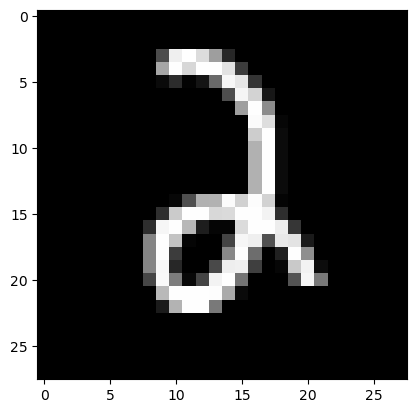

In [43]:
# Pick a random image from the test set
import matplotlib.pyplot as plt

# Pick a random image rom the test set
index = np.random.randint(len(test_set))

# Get the image and the label
image = test_set.images[index]
label = test_set.labels[index]

# Forward pass
pred = model.forward(image.reshape(1, -1))

# Get the predicted class
predicted_class = np.argmax(pred)

# Display the image
plt.imshow(image.reshape(28, 28), cmap="gray")

# Print the predicted class and the true class
print("Model prediction:", predicted_class)